# 신경망의 이해 - 퍼셉트론

## #01. 준비작업

### 1. 패키지 참조하기


In [27]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from helper.util import *
from helper.plot import *

from tensorflow.keras.models import Sequential # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense      # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import SGD, RMSprop    # 옵티마이저
from tensorflow.keras.losses import mse        # OR게이트에서 사용할 활성화 함수

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## #02. AND 게이트

### [1] 데이터 가져오기

훈련을 위한 데이터 자체가 워낙 양이 적기 때문에 이 예제는 훈련/검증 데이터를 분할하지 않음


In [28]:
origin = my_read_excel("https://data.hossam.kr/mldata/and.xlsx", info=False)

### [2] 독립, 종속 변수 분리


In [29]:
x = origin.drop(labels="target", axis=1)
y = origin["target"]
rows, cols = x.shape
rows, cols

(4, 2)

### [3] 훈련 모델 적합


In [30]:
model = Sequential()
# 1차원의 데이터를 입력으로 받고, cols개의 출력을 가지며 활성화 함수로 linear를 사용하는 첫 번째 Dense 층
model.add(Dense(1, input_shape=(cols,), activation="linear"))
model.compile(optimizer=SGD(), loss=mse, metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### [4] 학습하기


In [31]:
%%time
result = model.fit(x, y, epochs=500, verbose=0)
result

CPU times: total: 1.8 s
Wall time: 1.61 s


### [5] 학습 결과 

#### (1) 에폭별 정확도(acc)와 손실률(loss)


In [32]:
result_df = DataFrame(data=result.history)
result_df["epochs"] = result_df.index + 1
result_df

,loss,acc,epochs
0,1.085582,0.75,1
1,1.046529,0.75,2
2,1.009714,0.75,3
3,0.974998,0.75,4
4,0.942251,0.75,5
...,...,...,...
495,0.072810,1.00,496
496,0.072739,1.00,497
497,0.072667,1.00,498
498,0.072597,1.00,499


#### (2) 정확도, 손실률 시각화


In [33]:
rdf = result_df.melt(id_vars="epochs", var_name="metric", value_name="value")
rdf

,epochs,metric,value
0,1,loss,1.085582
1,2,loss,1.046529
2,3,loss,1.009714
3,4,loss,0.974998
4,5,loss,0.942251
...,...,...,...
995,496,acc,1.000000
996,497,acc,1.000000
997,498,acc,1.000000
998,499,acc,1.000000


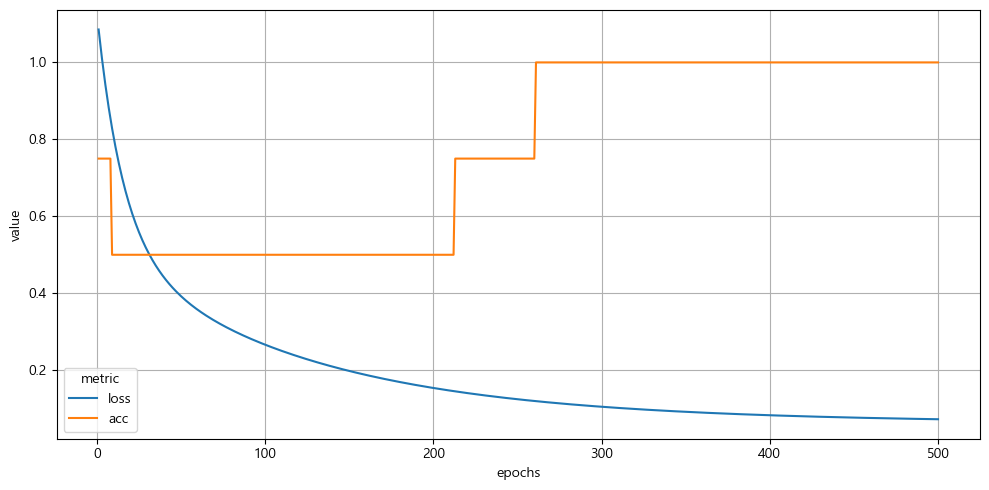

In [34]:
my_lineplot(df=rdf, xname="epochs", yname="value", hue="metric")

### [6] 모델 성능 평가

이 단계에서 검증 데이터를 활용해야 하지만 이 예제는 훈련/검증 데이터를 나누지 않았으므로 훈련데이터로 진행

In [35]:
ev = model.evaluate(x, y)
print("손실률: %0.2f%%, 정확도: %0.2f%%" % (ev[0], ev[1]))

1/1 [==============================] - 0s 81ms/step - loss: 0.0725 - acc: 1.0000
손실률: 0.07%, 정확도: 1.00%


### [7] 가중치, 편향 확인


In [36]:
weight, bias = model.get_weights()
print("가중치: %s" % weight)
print("편향: %s" % bias)

가중치: [[0.31626087]
 [0.43707708]]
편향: [-0.10371211]


### [8] 학습 결과 적용

#### (1) 단일 데이터에 대한 예측치 산정


In [37]:
for i in range(0, 2):
    for j in range(0, 2):
        r = model.predict(np.array([[i, j]]))
        print("입력: %d, %d => 출력: %0.2f" % (i, j, r[0][0]))
        print("%s AND %s => %s" % (bool(i), bool(j), bool(round(r[0, 0]))))

[scatterd] >WARNING> 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001A34877B9C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 33ms/step
입력: 0, 0 => 출력: -0.10
False AND False => False
1/1 [==============================] - 0s 16ms/step
입력: 0, 1 => 출력: 0.33
False AND True => False
1/1 [==============================] - 0s 16ms/step
입력: 1, 0 => 출력: 0.21
True AND False => False
1/1 [==============================] - 0s 16ms/step
입력: 1, 1 => 출력: 0.65
True AND True => True


#### (2) 학습 데이터 전체를 활용하여 예측값 만들기


In [38]:
r = model.predict(x)
r

[scatterd] >WARNING> 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001A34877B9C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 36ms/step


array([[-0.10371211],
       [ 0.21254876],
       [ 0.33336496],
       [ 0.6496259 ]], dtype=float32)

In [39]:
origin["pred"] = r.reshape(-1).round()
origin

,x1,x2,target,pred
0,0,0,0,-0.0
1,1,0,0,0.0
2,0,1,0,0.0
3,1,1,1,1.0


## #03. OR 게이트

### [1] 데이터 가져오기


In [40]:
origin = my_read_excel("https://data.hossam.kr/mldata/or.xlsx", info=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1      4 non-null      int64
 1   x2      4 non-null      int64
 2   target  4 non-null      int64
dtypes: int64(3)
memory usage: 228.0 bytes
None

데이터프레임 상위 5개 행
+----+------+------+----------+
|    |   x1 |   x2 |   target |
|----+------+------+----------|
|  0 |    0 |    0 |        0 |
|  1 |    1 |    0 |        1 |
|  2 |    0 |    1 |        1 |
|  3 |    1 |    1 |        1 |
+----+------+------+----------+

데이터프레임 하위 5개 행
+----+------+------+----------+
|    |   x1 |   x2 |   target |
|----+------+------+----------|
|  0 |    0 |    0 |        0 |
|  1 |    1 |    0 |        1 |
|  2 |    0 |    1 |        1 |
|  3 |    1 |    1 |        1 |
+----+------+------+----------+

기술통계
+--------+---------+--------+---------+-------+-------+-------+-------+-------+-------+
|        |   count |   mean |     std |

### [2] 독립, 종속 변수 분리


In [41]:
x = origin.drop(labels="target", axis=1)
y = origin["target"]
rows, cols = x.shape
rows, cols

(4, 2)

### [3] 모델 적합


In [42]:
model = Sequential()
model.add(Dense(1, activation="linear", input_shape=(cols,)))
model.compile(optimizer=SGD(), loss=mse, metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### [4] 학습하기


In [43]:
%time
result = model.fit(x, y, epochs=500, verbose=0)
result

CPU times: total: 0 ns
Wall time: 0 ns


### [5] 학습 결과


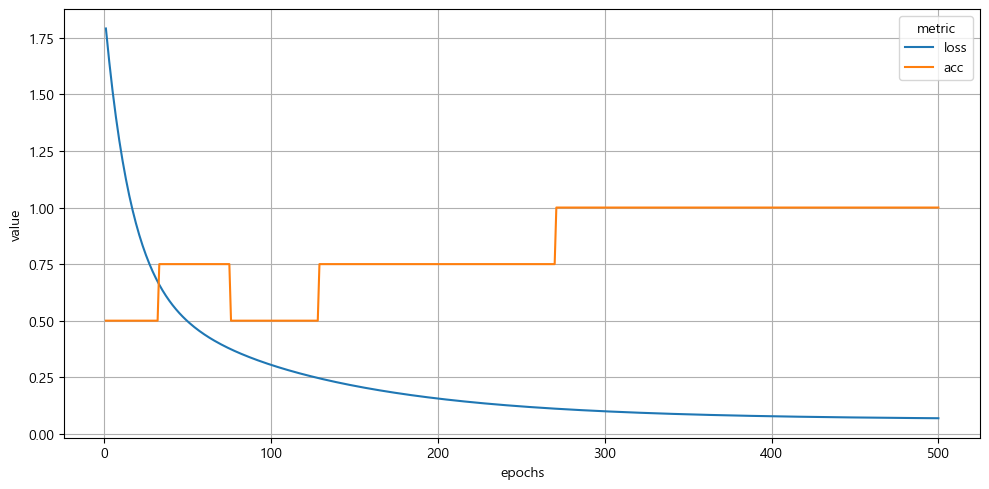

손실률: 0.07, 정확도: 1.00


In [44]:
result_df = DataFrame(result.history)
result_df["epochs"] = result_df.index + 1

rdf = result_df.melt(id_vars="epochs", var_name="metric", value_name="value")

my_lineplot(df=rdf, xname="epochs", yname="value", hue="metric")

ev = model.evaluate(x, y, verbose=0)
print("손실률: %0.2f, 정확도: %0.2f" % (ev[0], ev[1]))

### [6] 가중치, 편향


In [45]:
weight, bias = model.get_weights()
print("가중치: %s" % weight)
print("편향: %s" % bias)

가중치: [[0.34524554]
 [0.51872283]]
편향: [0.33067623]


### [7] 학습 결과 적용

##### 단일 데이터에 대한 예측치 산정


In [46]:
for i in range(0, 2):
    for j in range(0, 2):
        r = model.predict(np.array([[i, j]]))
        print("입력: %d, %d => 출력: %0.2f" % (i, j, r[0][0]))
        print("%s OR %s => %s" % (bool(i), bool(j), bool(round(r[0, 0]))))

1/1 [==============================] - 0s 31ms/step
입력: 0, 0 => 출력: 0.33
False OR False => False
1/1 [==============================] - 0s 26ms/step
입력: 0, 1 => 출력: 0.85
False OR True => True
1/1 [==============================] - 0s 31ms/step
입력: 1, 0 => 출력: 0.68
True OR False => True
1/1 [==============================] - 0s 16ms/step
입력: 1, 1 => 출력: 1.19
True OR True => True


##### 학습 데이터 전체를 활용하여 예측값 만들기


In [47]:
r = model.predict(x, verbose=0)
origin["pred"] = r.reshape(-1).round()
origin

,x1,x2,target,pred
0,0,0,0,0.0
1,1,0,1,1.0
2,0,1,1,1.0
3,1,1,1,1.0


## #04. XOR 게이트

### [1] 데이터 가져오기


In [48]:
origin = my_read_excel("https://data.hossam.kr/mldata/xor.xlsx", info=False)

### [2] 독립, 종속 변수 분리


In [49]:
x = origin.drop(labels="target", axis=1)
y = origin["target"]
rows, cols = x.shape
rows, cols

(4, 2)

### [3] 훈련 모델 적합


In [50]:
model = Sequential()
# 층이 2인 경우 --> 정확도 75%
# 층이 4인 경우 --> 정확도 75%
# 층이 8인 경우 --> 정확도 100%
# 층이 16인 경우 --> 정확도 100%
model.add(Dense(16, input_shape=(cols,), activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=RMSprop(), loss=mse, metrics=["acc"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### [4] 학습 및 학습 결과 확인


CPU times: total: 0 ns
Wall time: 0 ns


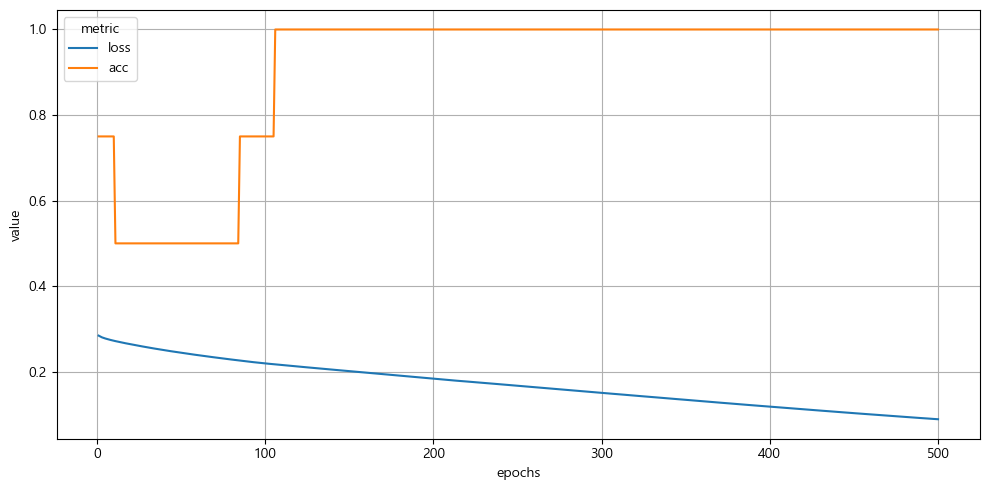

[scatterd] >WARNING> 5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x000001A34CF71080> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


손실률: 0.09, 정확도: 1.00


In [51]:
%time
result = model.fit(x, y, epochs=500, verbose=0)

result_df = DataFrame(result.history)
result_df["epochs"] = result_df.index + 1

rdf = result_df.melt(id_vars="epochs", var_name="metric", value_name="value")

my_lineplot(df=rdf, xname="epochs", yname="value", hue="metric")

ev = model.evaluate(x, y, verbose=0)
print("손실률: %0.2f, 정확도: %0.2f" % (ev[0], ev[1]))

### [5] 가중치, 편향


In [52]:
weights = model.get_weights()
weights

[array([[ 0.3927369 , -0.53186095, -0.4937157 ,  0.52132964, -0.4686592 ,
          0.43677634, -0.56692666,  0.52797514,  0.21179575, -0.50814205,
         -0.6649739 , -0.24976394,  0.70452577,  0.40426505, -0.5614838 ,
         -0.33118686],
        [ 0.39287654,  0.53209656,  0.49329302, -0.52246726,  0.4697584 ,
          0.43663782, -0.2081497 , -0.528934  , -0.47514325,  0.5076751 ,
          0.6635781 , -0.30602   ,  0.30358273,  0.08931026, -0.34746465,
          0.79635096]], dtype=float32),
 array([-3.9272052e-01, -9.3863130e-04, -3.4136081e-04, -3.3006538e-05,
         9.4574736e-04, -4.3504050e-01,  0.0000000e+00,  2.3145694e-06,
        -2.1194749e-01, -2.6915106e-04, -3.4221431e-04,  0.0000000e+00,
         2.5598044e-03,  2.6217490e-03,  0.0000000e+00,  4.1401857e-01],
       dtype=float32),
 array([[-0.5831998 ],
        [ 0.9684882 ],
        [ 0.8489796 ],
        [ 0.71126485],
        [ 0.70133704],
        [-0.81883585],
        [ 0.49890482],
        [ 0.5259442 

In [53]:
# 2차원 배열 - 입력층과 은닉층을 연결하는 가중치
print(weights[0].shape)

# 1차원 배열 - 은닉층의 편향
print(weights[1].shape)

# 2차원 배열 - 은닉층과 출력층을 연결하는 가중치
print(weights[2].shape)

# 1차원 배열 - 출력층의 편향
print(weights[3].shape)

(2, 16)
(16,)
(16, 1)
(1,)


### [6] 학습 결과 적용

##### 단일 데이터에 대한 예측치 산정


In [54]:
for i in range(0, 2):
    for j in range(0, 2):
        r = model.predict(np.array([[i, j]]))
        print("입력: %d, %d => 출력: %0.2f" % (i, j, r[0][0]))
        print("%s OR %s => %s" % (bool(i), bool(j), bool(round(r[0, 0]))))

1/1 [==============================] - 0s 47ms/step
입력: 0, 0 => 출력: 0.30
False OR False => False
1/1 [==============================] - 0s 24ms/step
입력: 0, 1 => 출력: 0.71
False OR True => True
1/1 [==============================] - 0s 18ms/step
입력: 1, 0 => 출력: 0.70
True OR False => True
1/1 [==============================] - 0s 18ms/step
입력: 1, 1 => 출력: 0.29
True OR True => False


##### 학습 데이터 전체를 활용하여 예측값 만들기


In [55]:
r = model.predict(x, verbose=0)
origin["pred"] = r.reshape(-1).round()
origin

,x1,x2,target,pred
0,0,0,0,0.0
1,1,0,1,1.0
2,0,1,1,1.0
3,1,1,0,0.0
